In [823]:
# Install required packages
!pip install pandas numpy matplotlib seaborn wordcloud nltk

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\program files (x86)\python\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [824]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import math

from collections import Counter
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

DATA_FOLDER = 'data'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [825]:
# Load the data
df = pd.read_csv(os.path.join(DATA_FOLDER, '93182_steam_games.csv'))

C:\Users\louis\AppData\Local\Temp\ipykernel_9488\154272785.py:2: DtypeWarning: Columns (3,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_FOLDER, '93182_steam_games.csv'))


In [826]:
# Get the first date of release and the last date of release
RELEASE_DATE = 'Release date'
# Remove the rows with a specific regex pattern
WRONG_DATE_REGEX = r'[a-zA-Z]{3} [0-9]{4}'
df = df[~df[RELEASE_DATE].str.contains(WRONG_DATE_REGEX)]

df[RELEASE_DATE] = pd.to_datetime(df[RELEASE_DATE], format='%b %d, %Y')

# Get the first date of release and the last date of release
first_date = df[RELEASE_DATE].min()
last_date = df[RELEASE_DATE].max()

print(f'The first date of release is {first_date}')
print(f'The last date of release is {last_date}')

The first date of release is 1997-06-30 00:00:00
The last date of release is 2025-12-31 00:00:00


In [827]:
# Only keep the columns we need
NAME = 'name'
GENRES = 'genres'
DESCRIPTION = 'description_raw'
DESCRIPTION_CLEANED = 'description_cleaned'
DESCRIPTION_LEMMATIZED = 'description_lemmatized'
DESCRIPTION_STEMMED = 'description_stemmed'
DESCRIPTION_NO_LEMMA_STEM = 'description_no_lemma_stem'

rename_columns = {
    'Name': NAME,
    'Genres': GENRES,
    'About the game': DESCRIPTION,
}

# Rename the columns
df = df.rename(columns=rename_columns)

# Only keep the columns we need
columns = [NAME, GENRES, DESCRIPTION]
df = df[columns]

# Drop rows with missing values
df = df.dropna()

# Drop duplicates of the same game name
df = df.drop_duplicates(subset=NAME)

# Replace special characters the correct way
chars = {
    '’': "'",
    '“': '"',
    '”': '"',
    '‘': "'",
    '’': "'",
    '–': '-',
    '—': '-',
    '…': '...',
}

for char, replacement in chars.items():
    df[DESCRIPTION] = df[DESCRIPTION].str.replace(char, replacement)
    

In [828]:
# Drop the rows with non latin characters
# df = df[df[NAME].str.contains(r'[^\x00-\x7F]+') == False]
df = df[df[DESCRIPTION].str.contains(r'[^\x00-\x7F]+') == False]

# Remove non alphanumeric characters in description with isalnum()
df[DESCRIPTION] = df[DESCRIPTION].apply(lambda x: ''.join([i for i in x if i.isalnum() or i.isspace()]))

# Remove the games with a description length less than 5 words
df = df[df[DESCRIPTION].apply(lambda x: len(x.split()) > 5)]

# Print the length of the dataset
print('Number of games:', len(df))

# Remove the rows containing some given words
words = ['sex', 'sexual content', 'nudity', 'violent', 'gore', 'mature', 'hentai', 'nsfw']
for word in words:
    # Remove the rows containing the word
    df = df[~df[NAME].str.lower().str.contains(word)]
    df = df[~df[GENRES].str.lower().str.contains(word)]
    df = df[~df[DESCRIPTION].str.lower().str.contains(word)]

# Print the length of the dataset
print('Number of games:', len(df))


Number of games: 71957
Number of games: 67919


In [829]:
# Extract the genres into a list
genres = df[GENRES].str.split(',')

# Make a set of all genres
all_genres = set()
for game_genres in genres:
    all_genres.update(game_genres)

print('All genres:', all_genres)
print('Number of genres:', len(all_genres))

All genres: {'Free To Play', 'Education', 'Action', '360 Video', 'Indie', 'Racing', 'Software Training', 'Accounting', 'Short', 'Utilities', 'Strategy', 'Early Access', 'Audio Production', 'Web Publishing', 'Design & Illustration', 'Game Development', 'Documentary', 'Movie', 'Animation & Modeling', 'Episodic', 'Casual', 'Sports', 'Simulation', 'RPG', 'Photo Editing', 'Tutorial', 'Adventure', 'Video Production', 'Massively Multiplayer'}
Number of genres: 29


In [830]:
def clean_genres(text):
    # Replace multiple commas and leading/trailing commas
    cleaned_text = re.sub(r',+|(^,)|(,$)', ',', text)
    # Remove any trailing comma left after cleaning
    return cleaned_text.strip(',')

In [831]:
def plot_genre_distribution(genre_counts, title: str='Distribution of genres', xlabel: str='Number of games', ylabel: str='Genre', width=10, height=10, add_text=True):
    # Print the number next to the genre bars
    plt.figure(figsize=(width, height))
    sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='Set1', hue=genre_counts.index)
    if add_text:
        for i in range(len(genre_counts)):
            # Add the number of games next to the bar centered in the middle according to the bar
            plt.text(genre_counts.values[i], i, genre_counts.values[i], va='center')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

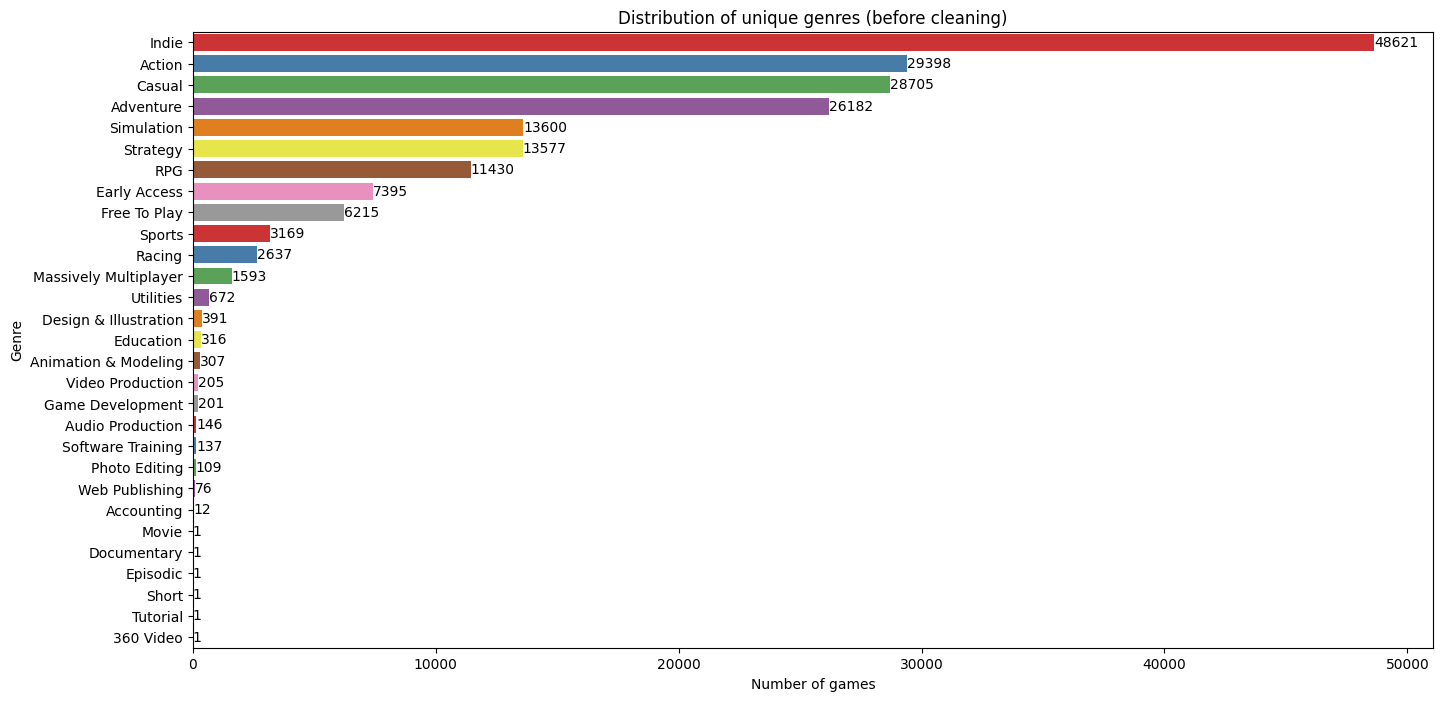

In [832]:
# Plot the distribution of unique genres
genre_counts = df[GENRES].str.split(',').explode().value_counts()
plot_genre_distribution(genre_counts, title='Distribution of unique genres (before cleaning)', width=16, height=8)

In [833]:
# Remove the given list of genres from the dataset
genres_to_remove = [
    'Video Production',
    'Utilities',
    'Movie',
    'Documentary',
    'Episodic',
    'Short',
    'Tutorial',
    '360 Video',
    'Software Training',
    'Design & Illustration',
    'Animation & Modeling',
    'Early Access',
    'Audio Production', 
    'Free To Play',
    'Accounting', 
    'Web Publishing',
    'Photo Editing',
    'Game Development',
    'Education',
    'Casual',
    'Indie',
]

# For each row check if the genres contain any of the genres to remove and remove them from the string of genres
for genre in genres_to_remove:
    df[GENRES] = df[GENRES].str.replace(genre, '')
    # Remove commas with regex that are left after removing the genre
    df[GENRES] = df[GENRES].apply(clean_genres)
    
    
# Remove the rows with empty genres
df = df[df[GENRES] != '']

# Print the length of the dataset
print('Number of games:', len(df))

Number of games: 57834


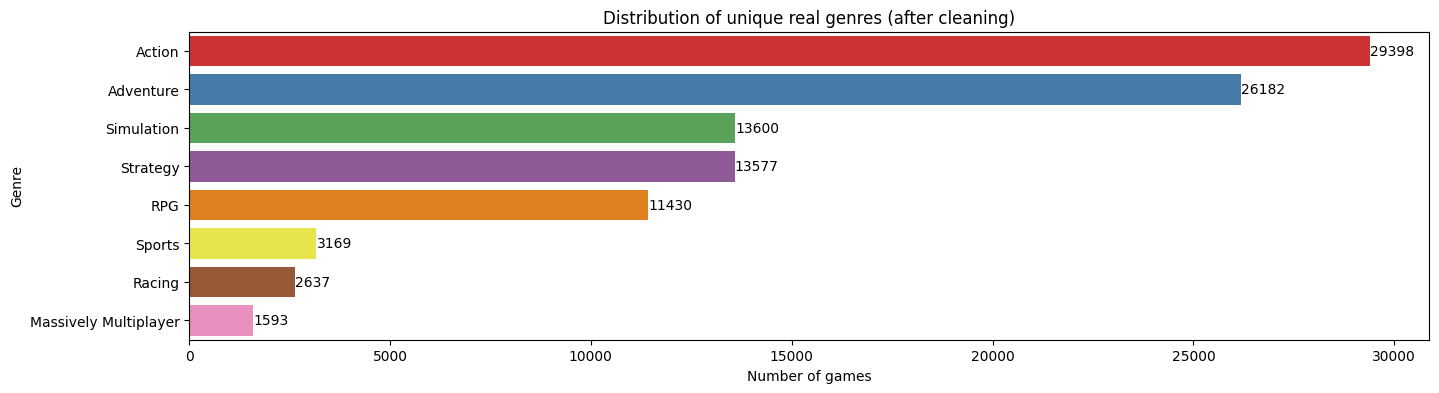

In [834]:
# Plot the distribution of unique genres
genre_counts = df[GENRES].str.split(',').explode().value_counts()
plot_genre_distribution(genre_counts, title='Distribution of unique real genres (after cleaning)', width=16, height=4)

Number of unique genres: 216


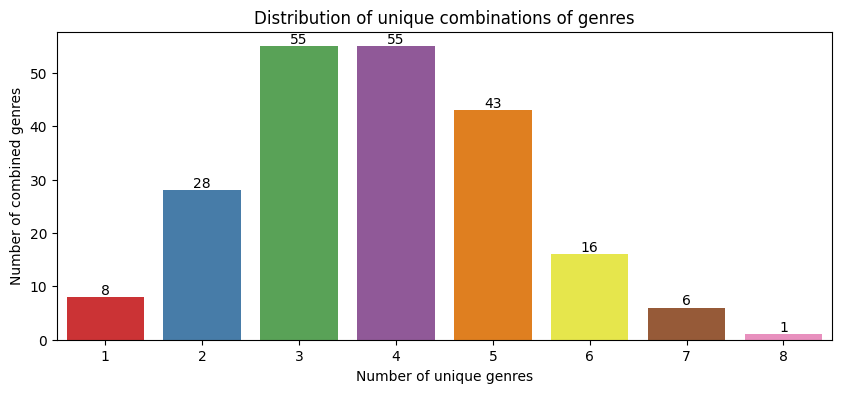

In [835]:
# Count the number of unique genres without splitting them
genre_counts = df[GENRES].value_counts()
print('Number of unique genres:', len(genre_counts))

# Split genres by comma and sort them to avoid duplicates with different orderings
unique_genre_combinations = df[GENRES].apply(lambda x: ','.join(sorted(x.split(',')))).unique()

# Count the number of genres in each unique combination
genre_combination_sizes = [len(combination.split(',')) for combination in unique_genre_combinations]

# Count the occurrences of each size
unique_size_counts = pd.Series(genre_combination_sizes).value_counts().sort_index()

# Plot the distribution of unique genre combinations
plt.figure(figsize=(10, 4))
# Create the barplot
ax = sns.barplot(x=unique_size_counts.index, y=unique_size_counts.values, palette='Set1', hue=unique_size_counts.index, legend=False)
# Get the positions of the bars (xticks are the bar centers)
bar_positions = ax.get_xticks()
# Add the number of games on top of each bar, centered in the middle
for i in range(len(unique_size_counts)):
    plt.text(bar_positions[i], unique_size_counts.values[i], unique_size_counts.values[i], ha='center', va='bottom')

plt.title('Distribution of unique combinations of genres')
plt.xlabel('Number of unique genres')
plt.ylabel('Number of combined genres')
plt.show()

Number of games: 28278


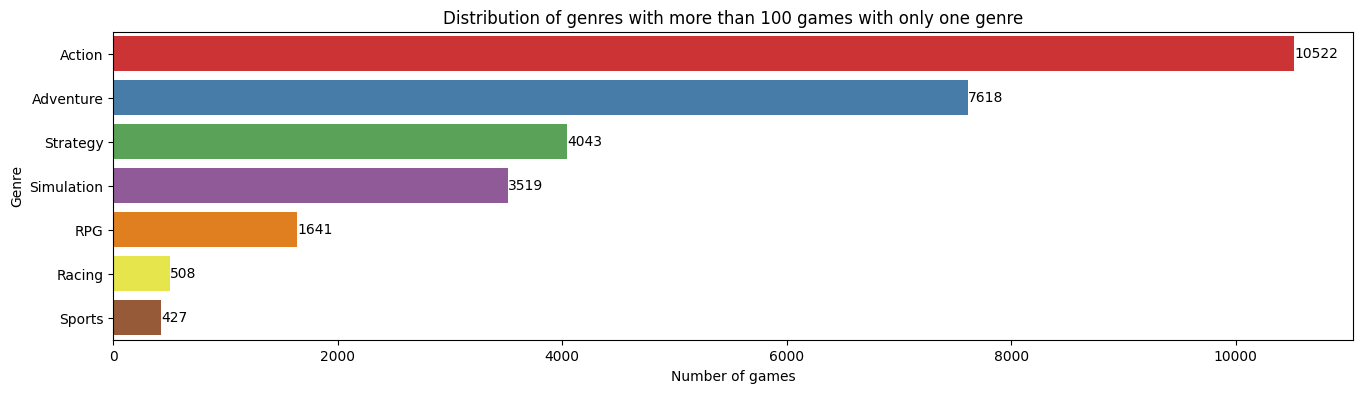

In [836]:
# Remove a game if it has more than 1 genres
df = df[df[GENRES].str.split(',').apply(len) <= 1]

# Plot the distribution of genres by keeping value 
genre_counts = df[GENRES].value_counts()

# Keep only genres with more than 100 games
genre_counts = genre_counts[genre_counts > 100]

# Remove all rows with genres that are less than 100 games
df = df[df[GENRES].isin(genre_counts.index)]

# Print the length of the dataset
print('Number of games:', len(df))

# Plot the distribution of unique genres
plot_genre_distribution(genre_counts, 'Distribution of genres with more than 100 games with only one genre', width=16, height=4)

In [837]:
# Keep the same number of games for each genre
min_genre_count = genre_counts.min()
df = df.groupby(GENRES).apply(lambda x: x.sample(min_genre_count, random_state=42)).reset_index(drop=True)

# Print the length of the dataset
print('Number of games:', len(df))
print('Number of genres:', len(df[GENRES].value_counts()))

Number of games: 2989
Number of genres: 7


In [838]:
# # Compute the average number of tokens in the description
# average_description_length = df[DESCRIPTION].apply(lambda x: len(x.split())).mean()
# print('Average description length:', average_description_length)

# # Compute the maximum number of tokens in the description
# max_description_length = df[DESCRIPTION].apply(lambda x: len(x.split())).max()
# print('Max description length:', max_description_length)

# # Compute the minimum number of tokens in the description
# min_description_length = df[DESCRIPTION].apply(lambda x: len(x.split())).min()
# print('Min description length:', min_description_length)

# # Count the number of games with a description length less than 10
# short_description_games = df[DESCRIPTION].apply(lambda x: len(x.split()) < 10).sum()
# print('Number of games with a description length less than 10:', short_description_games)

In [839]:
# Remove stopwords from the description
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def transform_words_to_remove(words_to_remove: list[str], operation: str=None):
    new_words = []
    if operation == 'lemmatization':
        for word in words_to_remove:
            new_words.append(lemmatizer.lemmatize(word.lower()))
    elif operation == 'stemming':
        for word in words_to_remove:
            new_words.append(stemmer.stem(word.lower()))
    else:
        new_words = words_to_remove
    return new_words

def main_preprocessing(text, words_to_remove: list[str], operation: str=None):
    new_words = []
       
    # Tokenize the description
    words = word_tokenize(text)
    
    for word in words:
        # If the word is a number, skip it
        if word.isdigit():
            continue
        
        # Put all words in lowercase
        word_lower = word.lower()
        
        # Remove stopwords from the description
        if word_lower in stop_words :
            continue
        
        # If we apply lemmatization
        if operation == 'lemmatization':
            # Apply lemmatization to the description
            word_lemma_or_stem = lemmatizer.lemmatize(word_lower)

            # Apply lemmatization to words to remove
            words_to_remove = transform_words_to_remove(words_to_remove, operation)
        
        # If we apply stemming
        elif operation == 'stemming':
            # Apply stemming to the description
            word_lemma_or_stem = stemmer.stem(word_lower)
            # Apply stemming to words to remove
            words_to_remove = transform_words_to_remove(words_to_remove, operation)
            
        else:
            # Keep the word as it is (raw)
            word_lemma_or_stem = word_lower
        
        # If a word is in the list of words to remove, skip it
        if word_lemma_or_stem in words_to_remove:
            continue
        
        # If the word is a number, after lemmatization, skip it (e.g. 90s -> 90)
        if word_lemma_or_stem.isdigit():
            continue
        
        # If the word is a single character, skip it
        if len(word_lemma_or_stem) == 1:
            continue
        
        # Remove verbs from the description
        # pos = pos_tag([word_lemma])[0][1]
        # if pos.startswith('VB'):
        #     continue
        
        # Add the word to the new list of words
        new_words.append(word_lemma_or_stem)
    
    return ' '.join(new_words)

# Specific for raw description
def remove_words_from_description(text, words_to_remove):
    # Tokenize the description
    words = word_tokenize(text)
    
    # Remove the words to remove from the raw description to avoid bias
    new_words = [word for word in words if word.lower() not in words_to_remove]
    
    return ' '.join(new_words)

In [840]:
# Add all game genres to the stopwords list and lowercase them
words_to_remove = df[GENRES].str.lower().str.split(',').explode().unique().tolist()

# Remove the words to remove from the raw description to avoid bias
df[DESCRIPTION] = df[DESCRIPTION].apply(lambda x: remove_words_from_description(x, words_to_remove))

# Add some additional words to remove without meaning related to the genre
words_to_remove.extend([
    'game', # Its the most common word in the description for all genres
    'player',
    'play',
    'feature',
    'different',
    'new',
    'one',
])

print('Words to remove:', words_to_remove)
# Apply the main preprocessing function to the description
# Raw description
df[DESCRIPTION_CLEANED] = df[DESCRIPTION].apply(lambda x: main_preprocessing(x, []))
# Lemmatized description
df[DESCRIPTION_LEMMATIZED] = df[DESCRIPTION].apply(lambda x: main_preprocessing(x, words_to_remove, 'lemmatization'))
# Stemmed description
df[DESCRIPTION_STEMMED] = df[DESCRIPTION].apply(lambda x: main_preprocessing(x, words_to_remove, 'stemming'))
# No lemmatization or stemming
df[DESCRIPTION_NO_LEMMA_STEM] = df[DESCRIPTION].apply(lambda x: main_preprocessing(x, words_to_remove))

Words to remove: ['action', 'adventure', 'rpg', 'racing', 'simulation', 'sports', 'strategy', 'game', 'player', 'play', 'feature', 'different', 'new', 'one']


In [841]:
# Save the reduced dataset
df.to_csv(os.path.join(DATA_FOLDER, 'steam_games_reduced.csv'), index=False)

In [842]:
# Load the reduced dataset
df_reduced = pd.read_csv(os.path.join(DATA_FOLDER, 'steam_games_reduced.csv'))

In [843]:
# Count the number of each word in the description according to the genre
def count_words(column: str, print_most_common: bool=True):
    word_counts = {}
    for genre in df_reduced[GENRES].unique():
        # Get all the descriptions for the genre
        descriptions = df_reduced[df_reduced[GENRES] == genre][column]
        
        # Count the number of each word in the description
        word_count = Counter()
        for description in descriptions:
            words = description.split()
            word_count.update(words)
        
        # Save the word count for the genre
        word_counts[genre] = word_count
        
        if print_most_common:
            # Print the most common words
            print(f"Most common words in column '{column}' for genre: {genre}")
            print(word_count.most_common(10))
        
    return word_counts

In [844]:
# For each word present in the genre add 1 to the variable of unique appearances in genres in a dictionary 
def get_unique_appearances(column, max_print: int=10):
    word_counts = count_words(column)
    
    unique_appearances = {}
    for genre, word_count in word_counts.items():
        for word in word_count.keys():
            # Initialize if word not in dictionary yet
            if word not in unique_appearances:
                unique_appearances[word] = [0, [], []]
            
            # Add 1 to the number of unique appearances
            unique_appearances[word][0] += 1
            
            # Add the count of the word in the current genre
            unique_appearances[word][1].append(word_count[word])
            
    # Express the word count in percentage in the unique appearances
    for word, appearances in unique_appearances.items():
        # Compute the percentage of the word in the genre
        appearances[2] = [round(count / sum(appearances[1]),2) for count in appearances[1]]

            
    # Sort the dictionary by the number of unique appearances and the total number of appearances
    unique_appearances = dict(sorted(unique_appearances.items(), key=lambda x: (x[1][0], sum(x[1][1])), reverse=True))

    # Print the number of unique appearances for each word
    print('Unique appearances of each word in genres:')
    # Header
    print(f'{"Word":15} {"Nb":3} {"Total appearances"} \t {"Percentage in genres"}')
    print('-' * 100)
    idx = 0
    for word, appearances in unique_appearances.items():
        idx += 1
        if idx >= max_print:
            break
        # Pretty print the word and the appearances like a table
        print(f'{word:15} {appearances[0]:3} {appearances[1]} \t {appearances[2]}')
    if len(unique_appearances) > max_print:
        print('...')
        
    return unique_appearances

In [845]:
# Find the words that appear in all genres and the frequency of the word in each genre is relatively equal
def get_words_in_all_genres(unique_appearances, nb_genres: int, boundary: float=0.045):
    words_in_all_genres = []
    middle_boundary = 1/nb_genres
    min_boundary = middle_boundary - boundary
    max_boundary = middle_boundary + boundary

    for word, appearances in unique_appearances.items():
        # If the word appears in all genres and the percentage of the word in the genre is relatively equal depending on the number of genres
        if appearances[0] == nb_genres and all([min_boundary < percentage < max_boundary for percentage in appearances[2]]):
            words_in_all_genres.append(word)
            
    print(words_in_all_genres)
    print(f"Number of words in all genres: {len(words_in_all_genres)}, within boundaries: {min_boundary} and {max_boundary}")
    
    return words_in_all_genres

# Remove the words from the text if it is in the list of words to remove
def remove_words(text, words_to_remove):
    words = text.split()
    new_words = [word for word in words if word not in words_to_remove]
    return ' '.join(new_words)

In [846]:
def get_words_to_remove(column: str, nb_genres: int):
    unique_appearances_lemma = get_unique_appearances(column=column)
    print()
    words_in_all_genres_lemma = get_words_in_all_genres(unique_appearances_lemma, nb_genres)
    print()
    return words_in_all_genres_lemma

In [847]:
# Remove the words that appear in all genres and the frequency of the word in each genre is relatively equal
nb_genres = len(df_reduced[GENRES].unique())

# Description lemmatized
words_to_remove_lemma = get_words_to_remove(DESCRIPTION_LEMMATIZED, nb_genres)
df_reduced[DESCRIPTION_LEMMATIZED] = df_reduced[DESCRIPTION_LEMMATIZED].apply(lambda x: remove_words(x, words_to_remove_lemma))

# Description stemmed
words_to_remove_stem = get_words_to_remove(DESCRIPTION_STEMMED, nb_genres)
df_reduced[DESCRIPTION_STEMMED] = df_reduced[DESCRIPTION_STEMMED].apply(lambda x: remove_words(x, words_to_remove_stem))

# Description no lemmatization or stemming
words_to_remove_no_lemma_stem = get_words_to_remove(DESCRIPTION_NO_LEMMA_STEM, nb_genres)
df_reduced[DESCRIPTION_NO_LEMMA_STEM] = df_reduced[DESCRIPTION_NO_LEMMA_STEM].apply(lambda x: remove_words(x, words_to_remove_no_lemma_stem))

Most common words in column 'description_lemmatized' for genre: Action
[('enemy', 442), ('level', 374), ('mode', 345), ('weapon', 280), ('time', 222), ('get', 197), ('world', 183), ('battle', 177), ('unique', 175), ('gameplay', 175)]
Most common words in column 'description_lemmatized' for genre: Adventure
[('story', 341), ('world', 336), ('puzzle', 332), ('find', 316), ('character', 211), ('way', 206), ('time', 198), ('level', 190), ('experience', 170), ('explore', 160)]
Most common words in column 'description_lemmatized' for genre: RPG
[('world', 456), ('character', 355), ('story', 287), ('battle', 272), ('system', 239), ('find', 218), ('time', 211), ('enemy', 197), ('unique', 193), ('dungeon', 193)]
Most common words in column 'description_lemmatized' for genre: Racing
[('race', 696), ('car', 599), ('track', 528), ('mode', 436), ('time', 333), ('level', 279), ('world', 232), ('speed', 203), ('get', 198), ('friend', 194)]
Most common words in column 'description_lemmatized' for genr

In [848]:
# Create a word cloud for the most common words in the description
def plot_word_cloud(column: str, max_words: int=50):
    word_counts = count_words(column=column, print_most_common=False)
    
    # Create a word cloud for each genre
    for genre, word_count in word_counts.items():
        # Convert the most common words to a dictionary (word -> frequency)
        common_words_dict = dict(word_count.most_common(max_words))
        
        wordcloud = WordCloud(width = 800, height = 400, 
                    background_color ='white', 
                    min_font_size = 10,
                    max_font_size = 100).generate_from_frequencies(common_words_dict)
        
        plt.figure(figsize = (8, 4), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.title(f"Word cloud of '{column}' for genre: {genre}")
        plt.show()
        
def plot_word_cloud_mosaic(column: str, max_words: int=50, max_columns: int=3):
    word_counts = count_words(column=column, print_most_common=False)
    
    # Determine the number of rows based on the number of genres and max columns
    num_genres = len(word_counts)
    num_rows = math.ceil(num_genres / max_columns)
    
    # Create subplots for the mosaic
    fig, axes = plt.subplots(num_rows, max_columns, figsize=(max_columns * 6, num_rows * 4))
    fig.suptitle(f"Word Clouds of '{column}' by Genre", fontsize=16)
    
    # Flatten axes for easy iteration (in case max_columns > 1)
    axes = axes.flatten()
    
    # Plot each word cloud in the mosaic
    for i, (genre, word_count) in enumerate(word_counts.items()):
        # Convert the most common words to a dictionary (word -> frequency)
        common_words_dict = dict(word_count.most_common(max_words))
        
        wordcloud = WordCloud(width=800, height=400, 
                              background_color='white', 
                              min_font_size=10,
                              max_font_size=100).generate_from_frequencies(common_words_dict)
        
        # Plot the word cloud in the appropriate subplot
        axes[i].imshow(wordcloud)
        axes[i].axis("off")
        axes[i].set_title(f"{genre}", fontsize=14)
    
    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout(pad=2)
    plt.show()

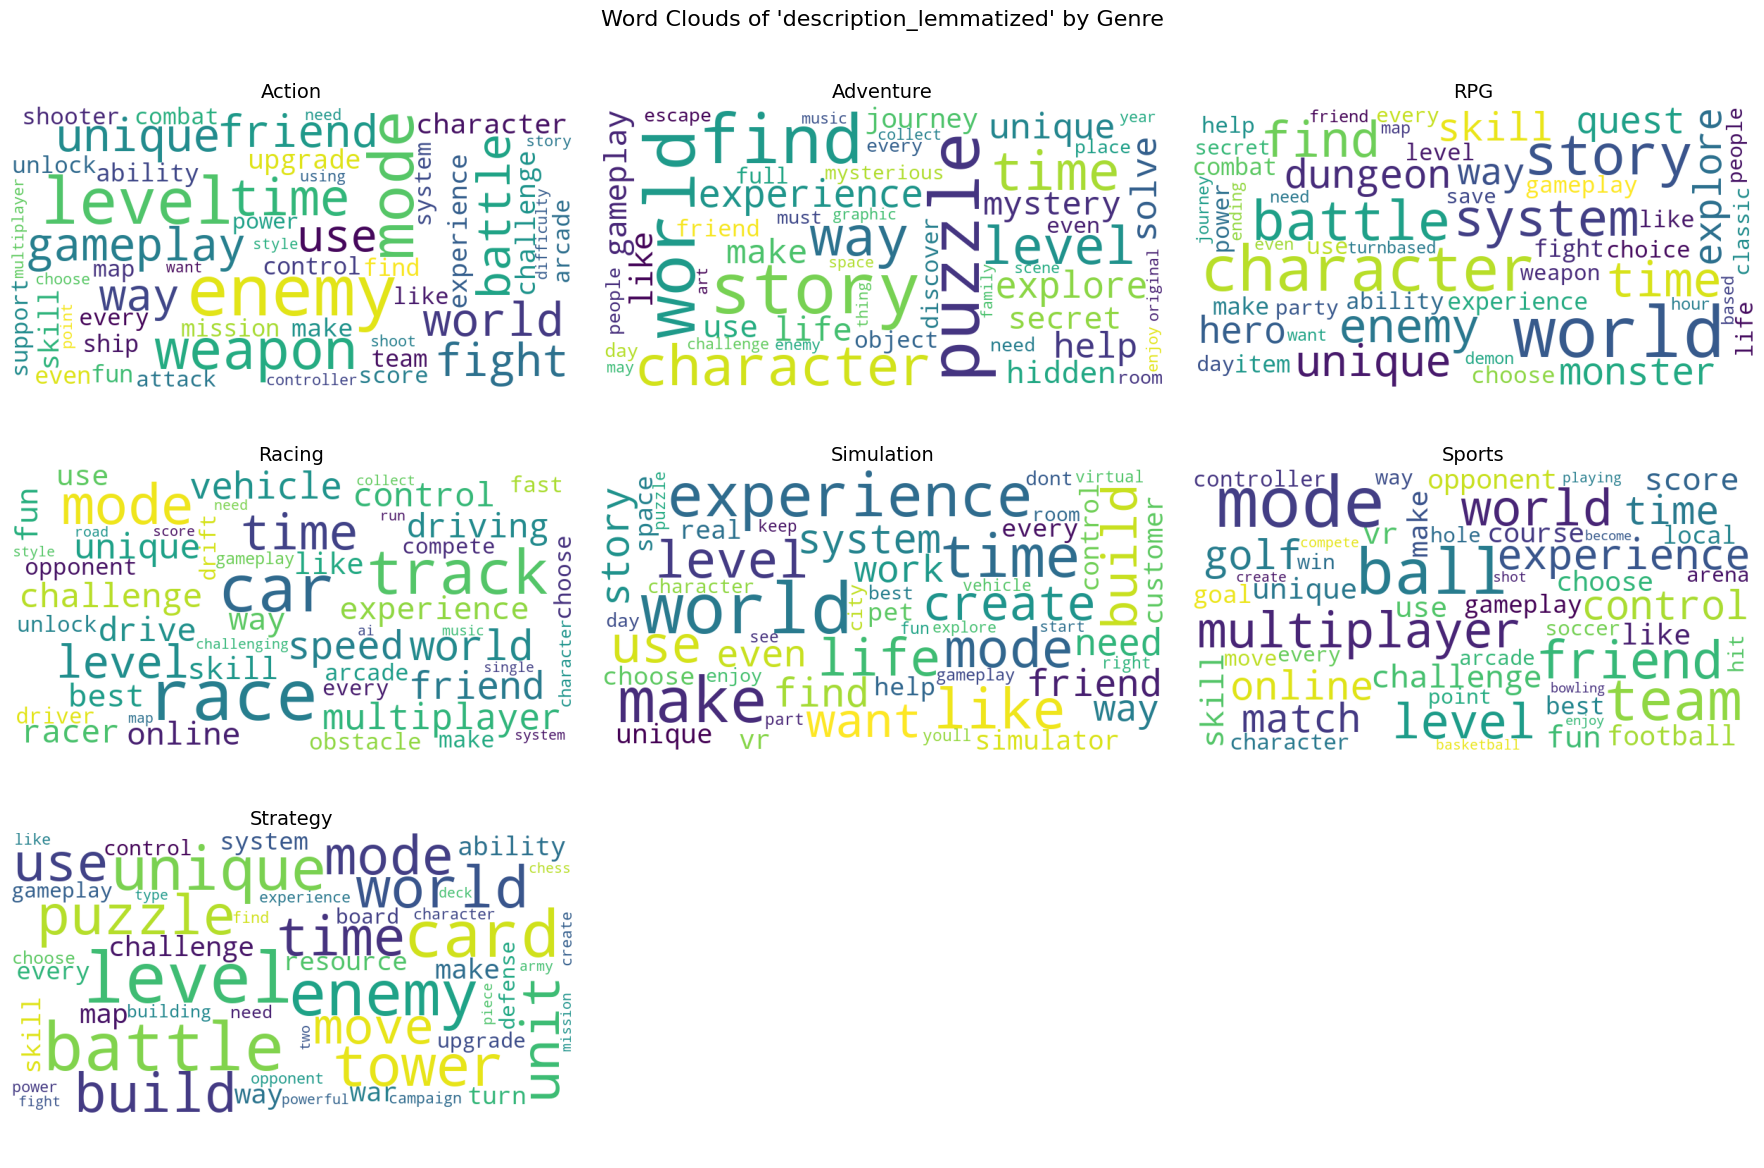

In [849]:
# Plot the word cloud for the lemmatized description
plot_word_cloud_mosaic(DESCRIPTION_LEMMATIZED)

In [850]:
# Save the reduced dataset
df_reduced.to_csv(os.path.join(DATA_FOLDER, 'steam_games_reduced_2.csv'), index=False)